In [6]:
import os
import random
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

ROOT_DIR = "./data"
RANDOM_SEED = 110

In [40]:
df = pd.read_csv("../data/pre_1.csv", header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 156 entries, Equipment_Dam to Workorder Category
dtypes: float64(72), int64(76), object(8)
memory usage: 48.2+ MB


## Fill2

1. 단일값 제거

In [41]:
# Θ 관련 열 모두 제거
# X standby position 제거

df.drop(["CURE END POSITION Θ Collect Result_Fill2", "CURE STANDBY POSITION X Collect Result_Fill2", "CURE STANDBY POSITION Θ Collect Result_Fill2", "CURE START POSITION Θ Collect Result_Fill2"], axis=1, inplace=True)
df.drop(["DISCHARGED SPEED OF RESIN Collect Result_Fill2", "DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill2", "DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill2", "DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill2", "Dispense Volume(Stage1) Collect Result_Fill2", "Dispense Volume(Stage2) Collect Result_Fill2", "Dispense Volume(Stage3) Collect Result_Fill2"], axis=1, inplace=True)

In [42]:
Fill2_df = df.loc[:, df.columns.str.contains("_Fill2")]

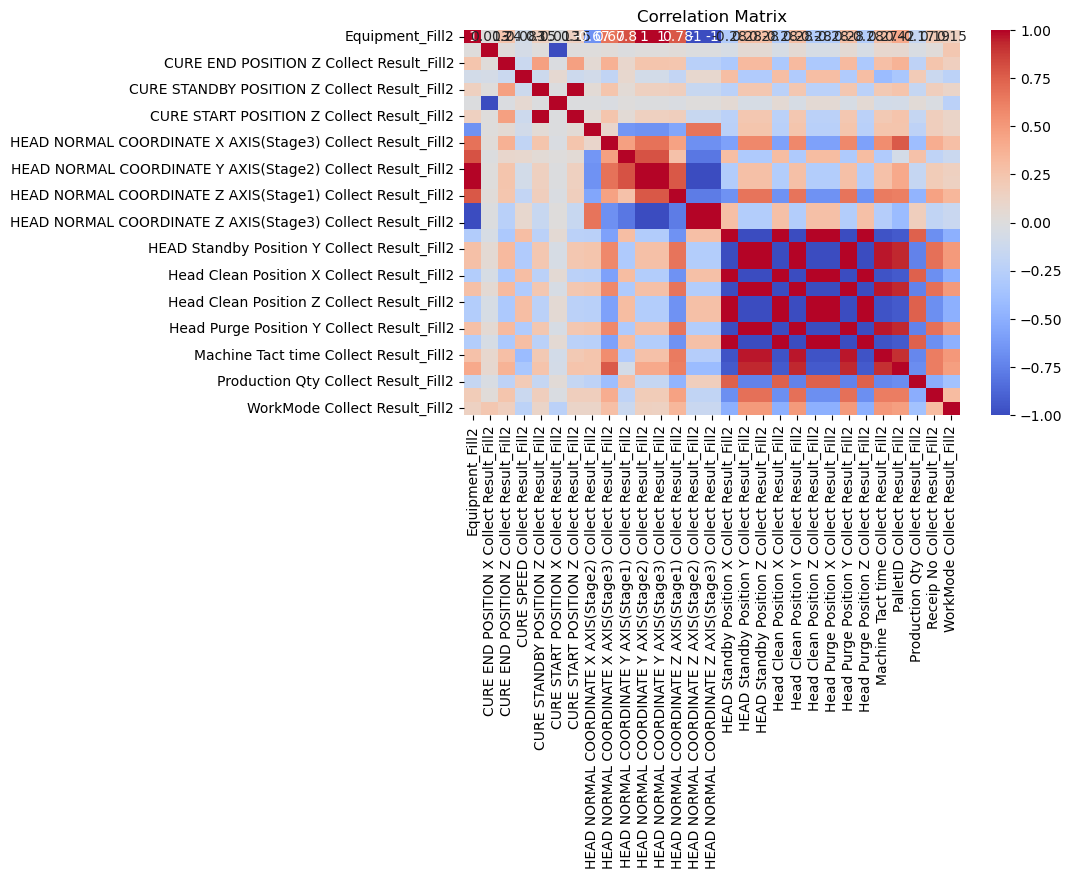

In [43]:
# heatmap

heatmap: plt.figure(figsize=(8, 5))
sns.heatmap(Fill2_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix');

2. Cure End/Standby/Start Position X, Z  & Discharged Speed - PCA

In [24]:
Fill2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 30 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Equipment_Fill2                                             40506 non-null  int64  
 1   CURE END POSITION X Collect Result_Fill2                    40506 non-null  int64  
 2   CURE END POSITION Z Collect Result_Fill2                    40506 non-null  int64  
 3   CURE SPEED Collect Result_Fill2                             40506 non-null  int64  
 4   CURE STANDBY POSITION Z Collect Result_Fill2                40506 non-null  int64  
 5   CURE START POSITION X Collect Result_Fill2                  40506 non-null  int64  
 6   CURE START POSITION Z Collect Result_Fill2                  40506 non-null  int64  
 7   DISCHARGED SPEED OF RESIN Collect Result_Fill2              40506 non-null  int64  
 

In [44]:
cure_df = Fill2_df.iloc[:, 1:7]
cure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 6 columns):
 #   Column                                        Non-Null Count  Dtype
---  ------                                        --------------  -----
 0   CURE END POSITION X Collect Result_Fill2      40506 non-null  int64
 1   CURE END POSITION Z Collect Result_Fill2      40506 non-null  int64
 2   CURE SPEED Collect Result_Fill2               40506 non-null  int64
 3   CURE STANDBY POSITION Z Collect Result_Fill2  40506 non-null  int64
 4   CURE START POSITION X Collect Result_Fill2    40506 non-null  int64
 5   CURE START POSITION Z Collect Result_Fill2    40506 non-null  int64
dtypes: int64(6)
memory usage: 1.9 MB


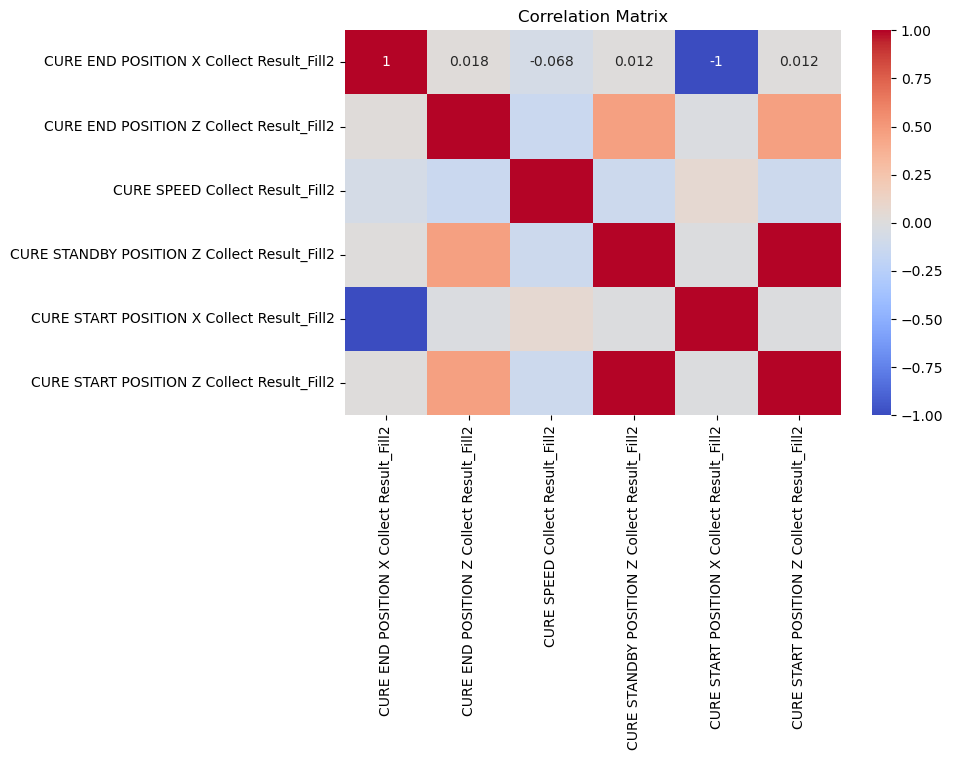

In [45]:
# cure_df heatmap
# Z의 standby/start position, X의 end/start position끼리 상관성 높음
# discharged speed, z standby 상관성 높음

heatmap: plt.figure(figsize=(8, 5))
sns.heatmap(cure_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix');

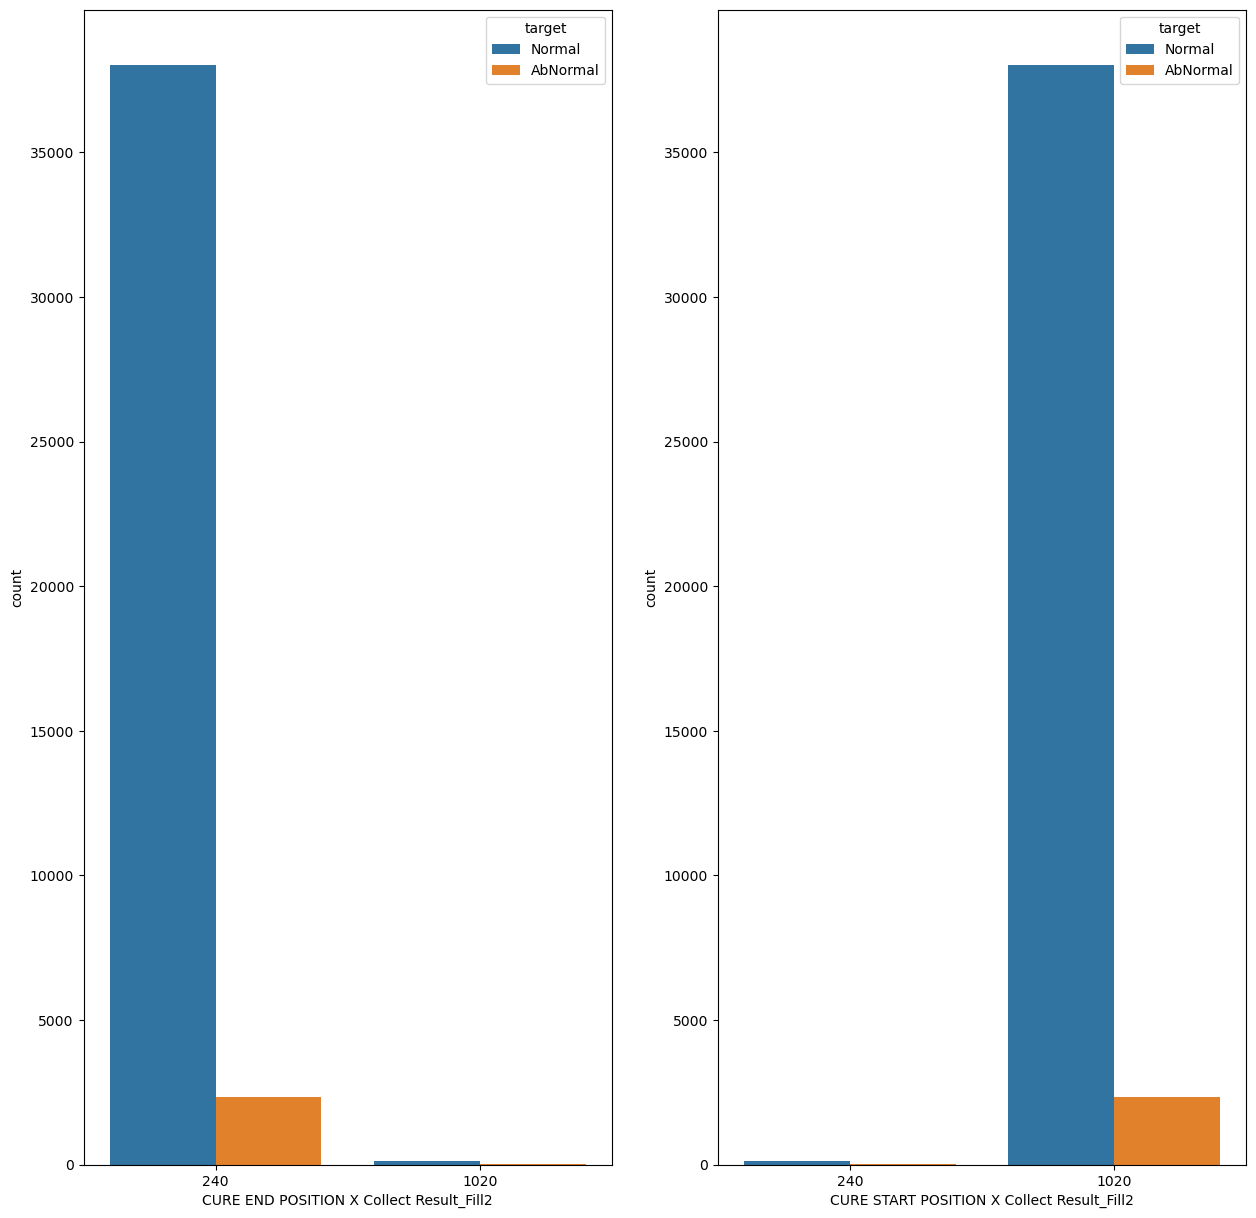

In [34]:
# x끼리 시각화
# 대칭인데 PCA(?) => 일단 안함

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
sns.countplot(x='CURE END POSITION X Collect Result_Fill2', hue="target", data=df, ax=axes[0]);
sns.countplot(x='CURE START POSITION X Collect Result_Fill2', hue="target", data=df, ax=axes[1]);

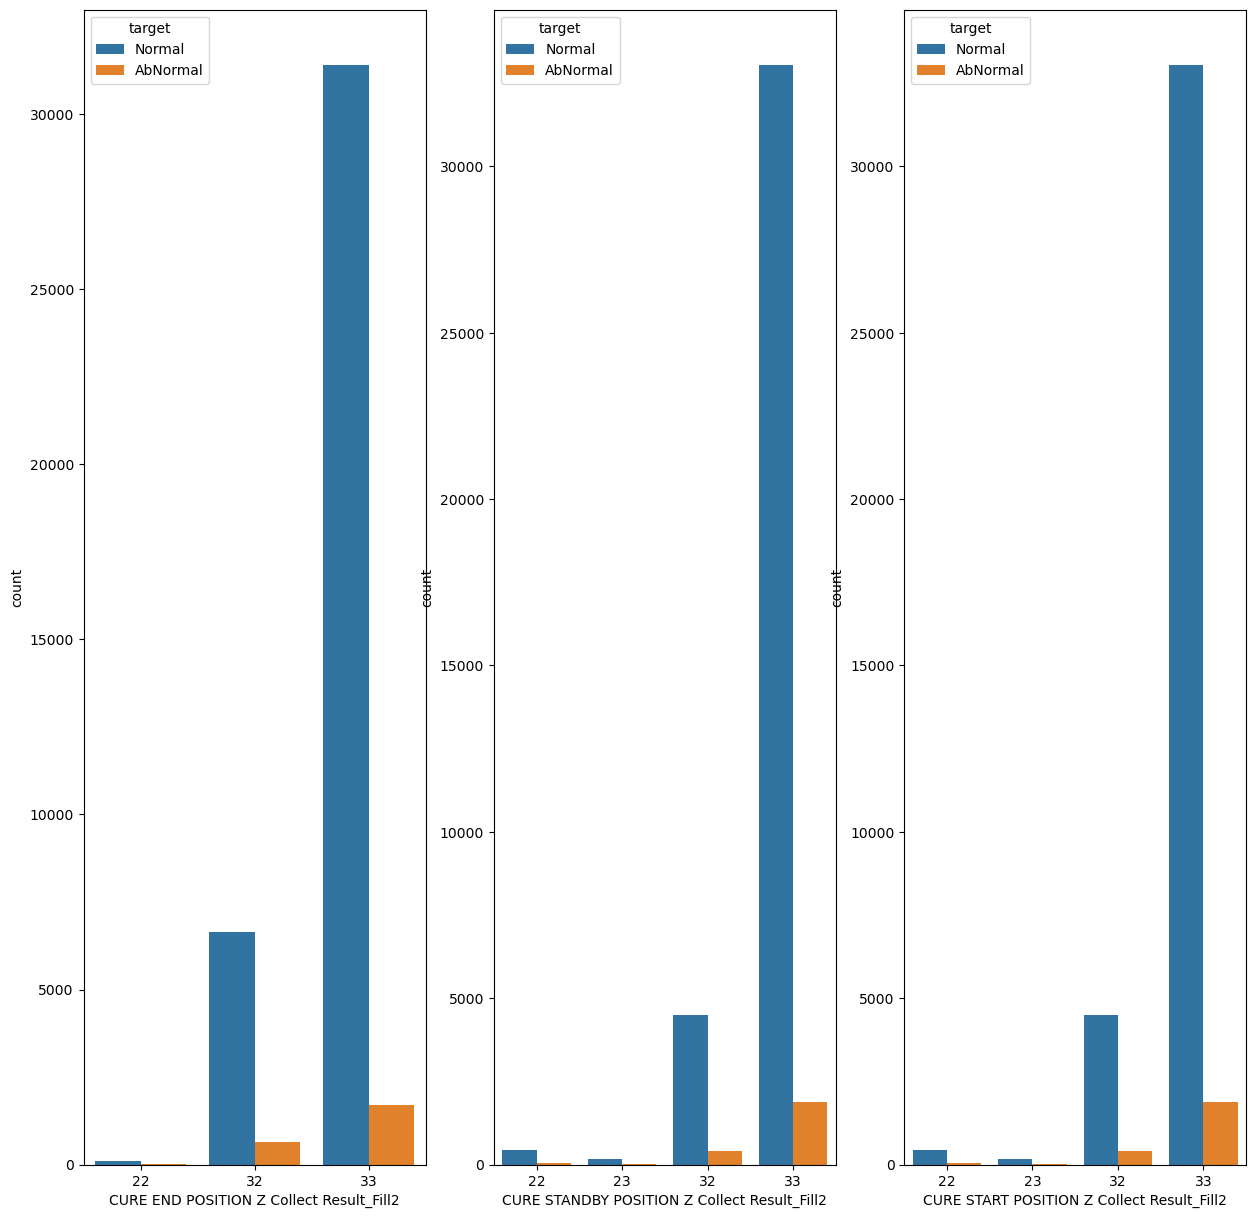

In [46]:
# z끼리 시각화

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
sns.countplot(x='CURE END POSITION Z Collect Result_Fill2', hue="target", data=df, ax=axes[0]);
sns.countplot(x='CURE STANDBY POSITION Z Collect Result_Fill2', hue="target", data=df, ax=axes[1]);
sns.countplot(x='CURE START POSITION Z Collect Result_Fill2', hue="target", data=df, ax=axes[2]);

In [47]:
# Z cure end/standby/start => PCA 열 생성

x = df[["CURE END POSITION Z Collect Result_Fill2", "CURE STANDBY POSITION Z Collect Result_Fill2", "CURE START POSITION Z Collect Result_Fill2"]]
x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

from sklearn.decomposition import PCA

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
pca_result = pca.fit_transform(x)

df["Z Cure end/standby/start PCA_Fill2"] = pca_result

3. Head Normal X/Y/Z Stage 1/2/3 - PCA 안함. grouping이 필요하다고 개인적으로 생각..!

In [51]:
normal_df = Fill2_df.iloc[:, 7:14]
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 7 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2  40506 non-null  float64
 1   HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2  40506 non-null  float64
 2   HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2  40506 non-null  float64
 3   HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2  40506 non-null  float64
 4   HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2  40506 non-null  float64
 5   HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2  40506 non-null  float64
 6   HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2  40506 non-null  float64
dtypes: float64(7)
memory usage: 2.2 MB


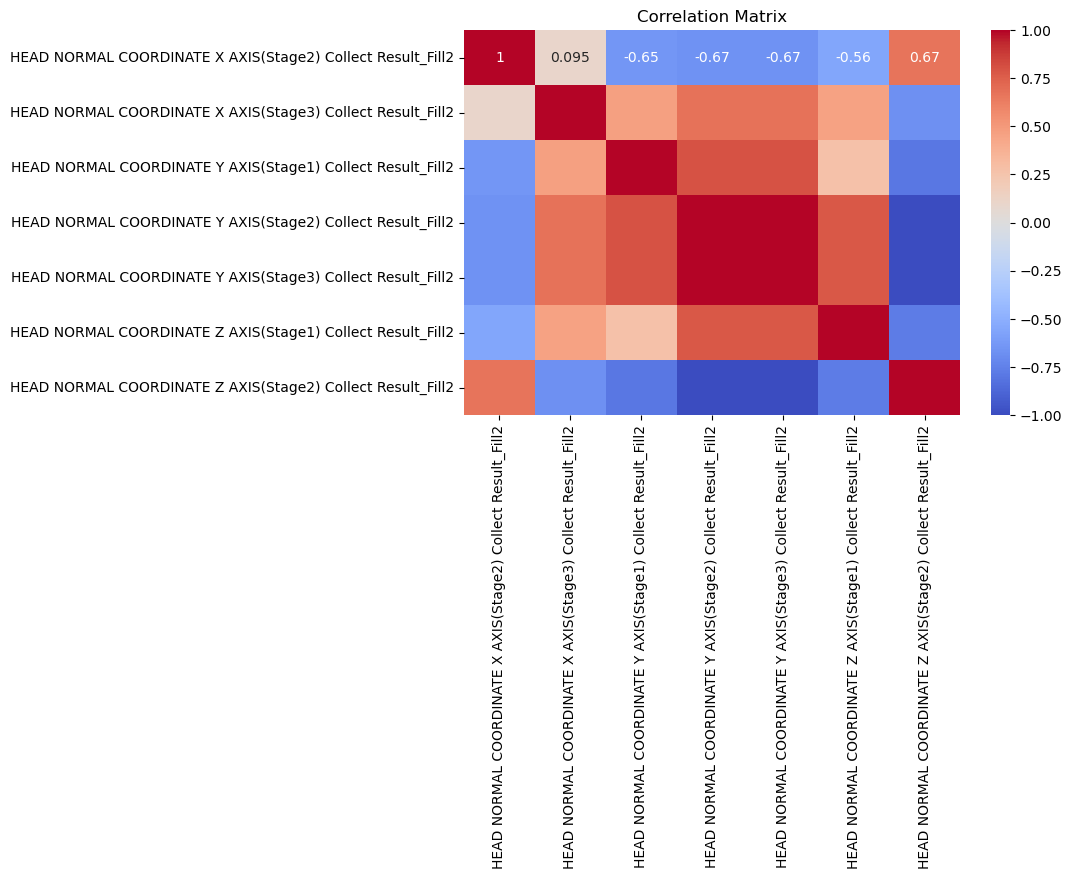

In [52]:
# normal_df heatmap

heatmap: plt.figure(figsize=(8, 5))
sns.heatmap(normal_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix');

In [53]:
normal_df.corr()

,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2,1.000000,0.095403,-0.646389,-0.670215,-0.670342,-0.557917,0.670278
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,0.095403,1.000000,0.465118,0.673745,0.673622,0.453979,-0.673684
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2,-0.646389,0.465118,1.000000,0.803173,0.803231,0.270211,-0.803202
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,-0.670215,0.673745,0.803173,1.000000,1.000000,0.777998,-1.000000
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2,-0.670342,0.673622,0.803231,1.000000,1.000000,0.777970,-1.000000
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2,-0.557917,0.453979,0.270211,0.777998,0.777970,1.000000,-0.777984
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,0.670278,-0.673684,-0.803202,-1.000000,-1.000000,-0.777984,1.000000


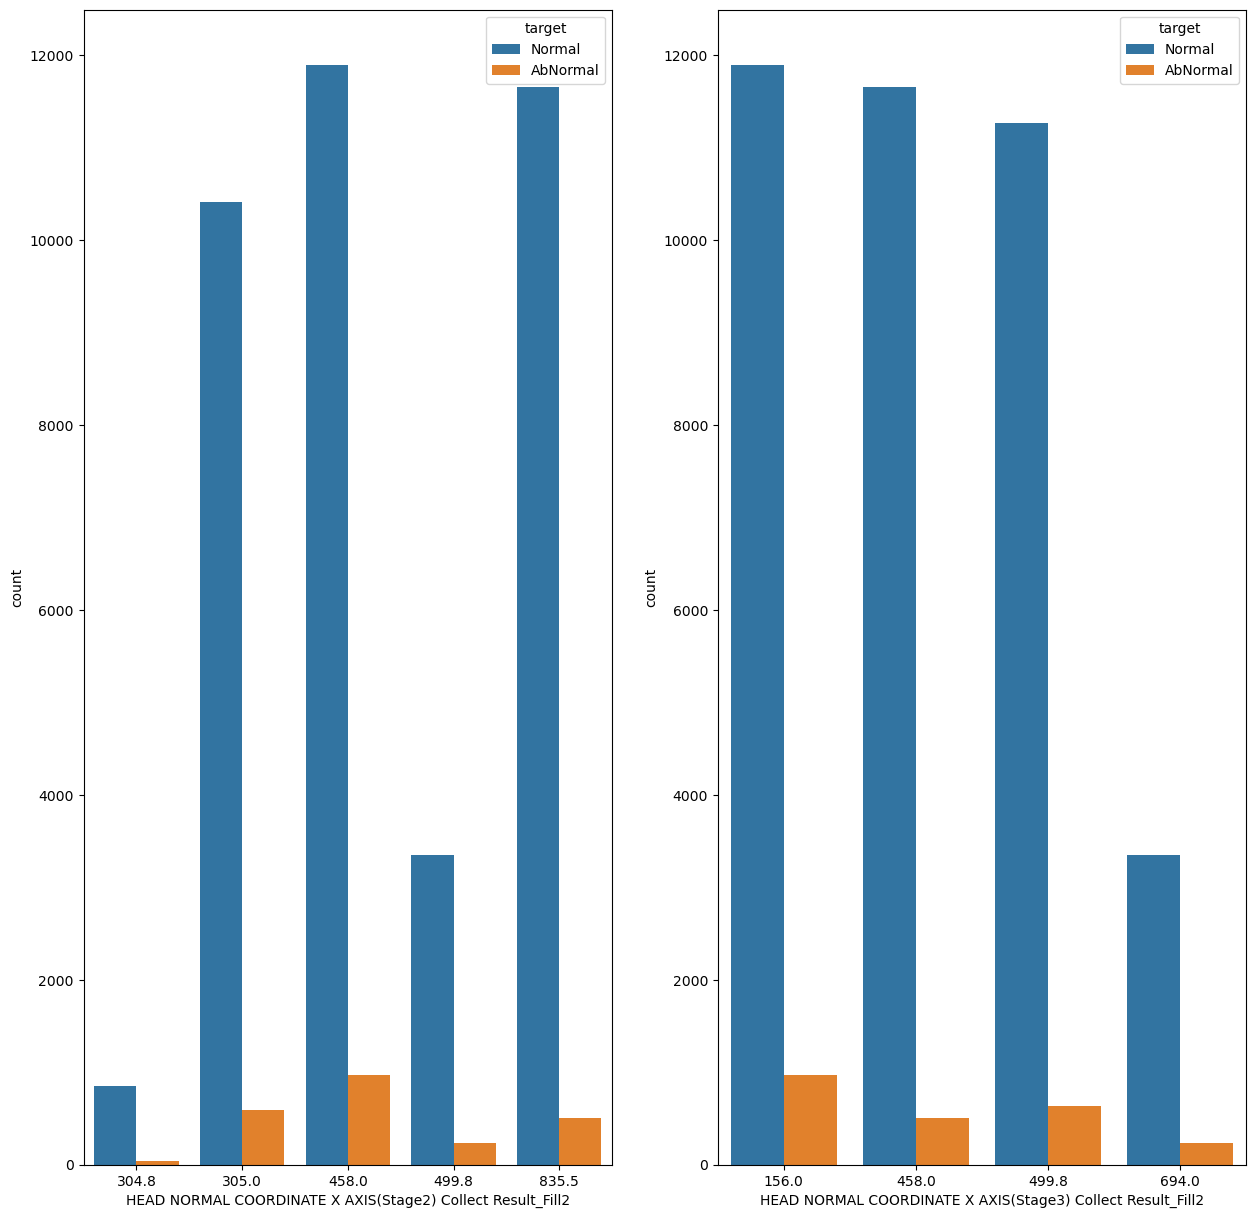

In [54]:
# X Stage 1/2 시각화

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
sns.countplot(x='HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2', hue="target", data=df, ax=axes[0]);
sns.countplot(x='HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2', hue="target", data=df, ax=axes[1]);

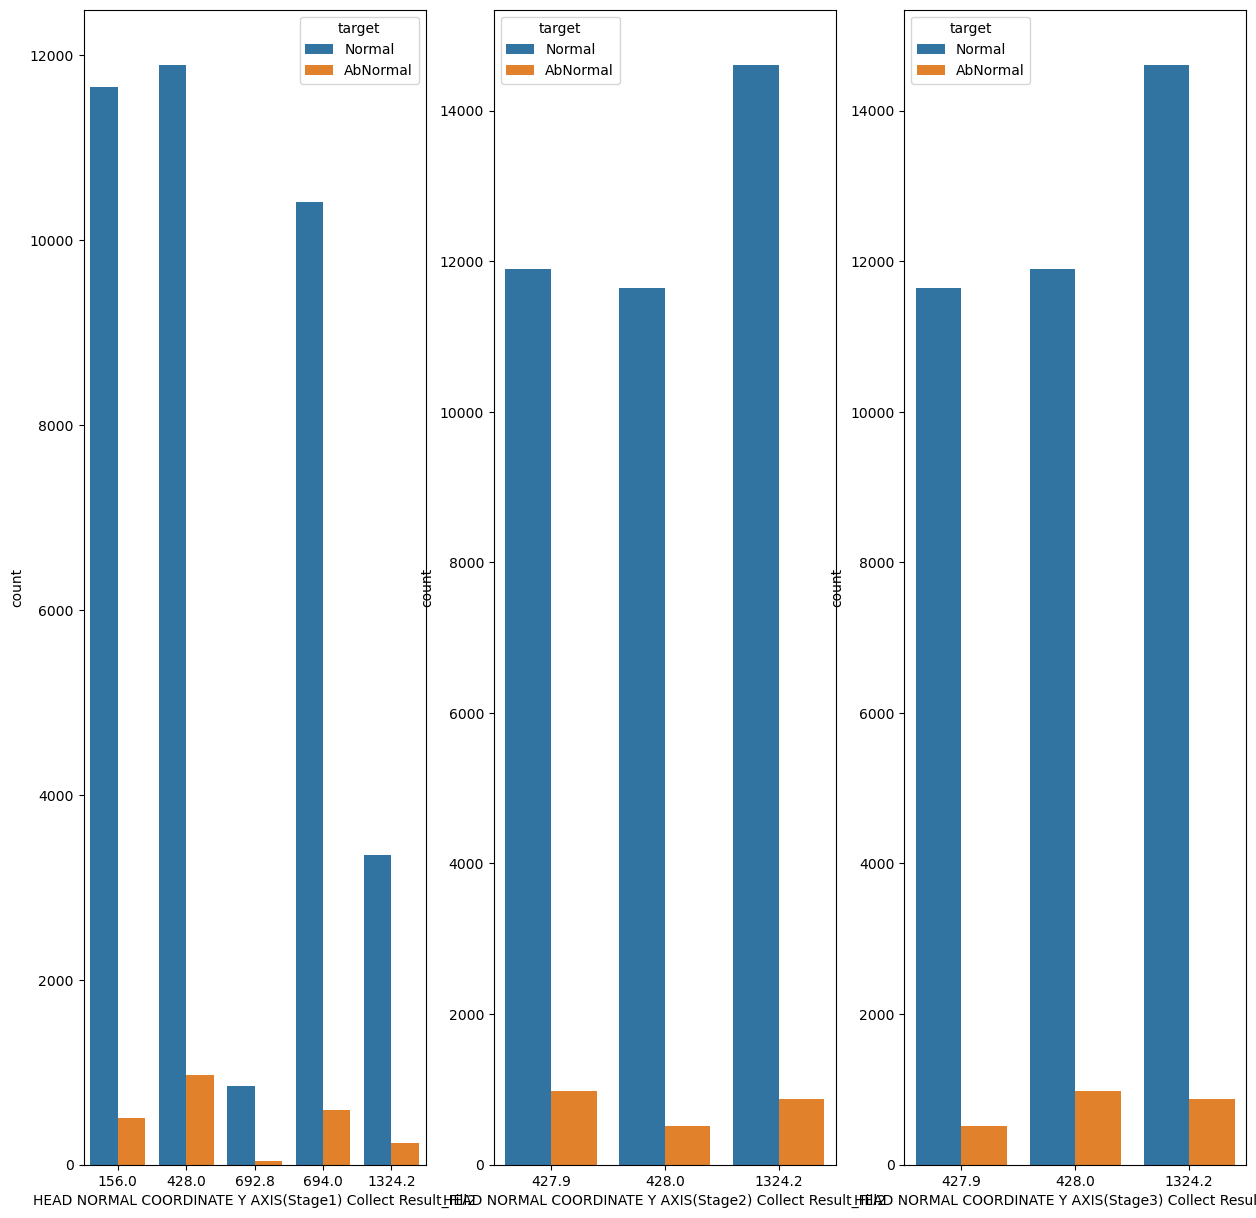

In [55]:
# Y Stage 1/2/3 시각화

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
sns.countplot(x='HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2', hue="target", data=df, ax=axes[0]);
sns.countplot(x='HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2', hue="target", data=df, ax=axes[1]);
sns.countplot(x='HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2', hue="target", data=df, ax=axes[2]);

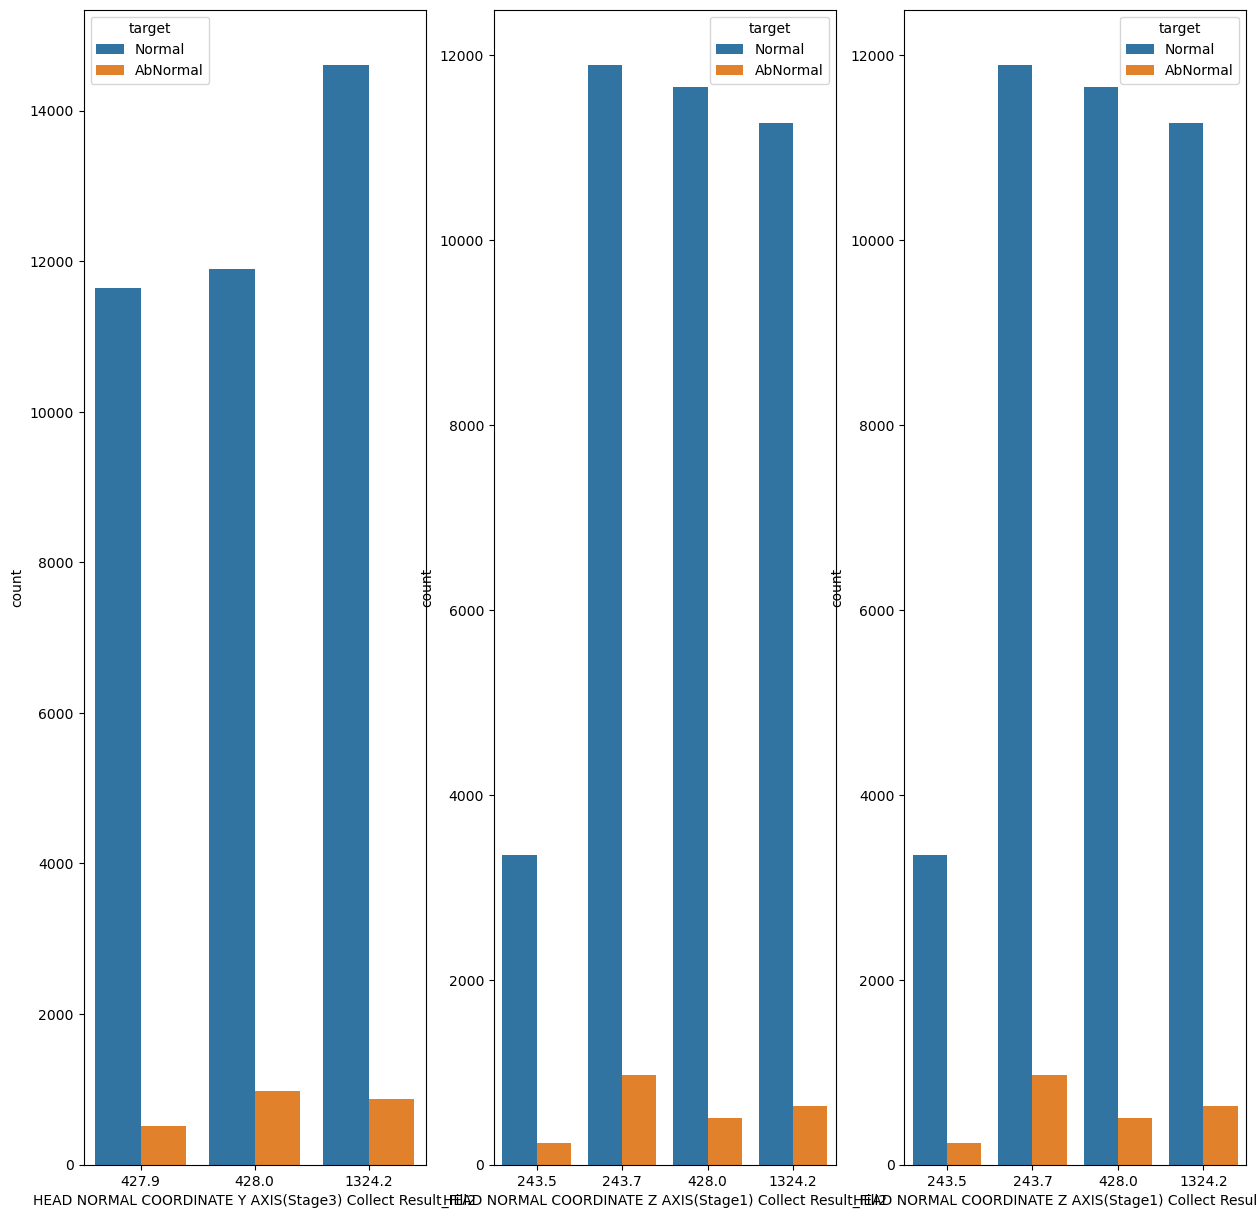

In [56]:
# Z Stage 1/2/3 시각화

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
sns.countplot(x='HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2', hue="target", data=df, ax=axes[0]);
sns.countplot(x='HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2', hue="target", data=df, ax=axes[1]);
sns.countplot(x='HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2', hue="target", data=df, ax=axes[2]);

In [57]:
# 아래 df 때문에 나는 grouping을 하는게 맞다고 봐!

normal_df.value_counts()

HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2  HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2  HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2  HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2  HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2  HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2  HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2
458.0                                                       156.0                                                       428.0                                                       427.9                                                       428.0                                                       243.7                                                       243.7                                                         12868
835.5                                                       458.0                                                       156.0                            

3. Standby/Clean/Purge X/Y/Z -> PCA

In [59]:
SCP_df = Fill2_df.iloc[:, 15:24]
SCP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   HEAD Standby Position X Collect Result_Fill2  40506 non-null  float64
 1   HEAD Standby Position Y Collect Result_Fill2  40506 non-null  int64  
 2   HEAD Standby Position Z Collect Result_Fill2  40506 non-null  int64  
 3   Head Clean Position X Collect Result_Fill2    40506 non-null  int64  
 4   Head Clean Position Y Collect Result_Fill2    40506 non-null  int64  
 5   Head Clean Position Z Collect Result_Fill2    40506 non-null  float64
 6   Head Purge Position X Collect Result_Fill2    40506 non-null  float64
 7   Head Purge Position Y Collect Result_Fill2    40506 non-null  int64  
 8   Head Purge Position Z Collect Result_Fill2    40506 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.8 MB


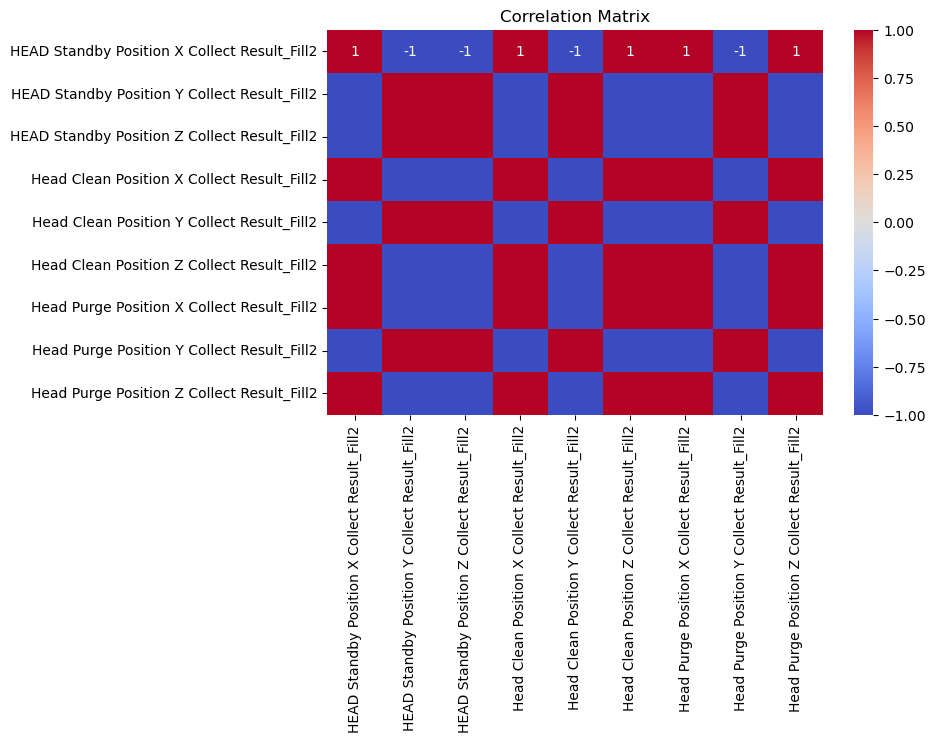

In [60]:
# heatmap

heatmap: plt.figure(figsize=(8, 5))
sns.heatmap(SCP_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix');

<Axes: xlabel='Head Purge Position Z Collect Result_Fill2', ylabel='count'>

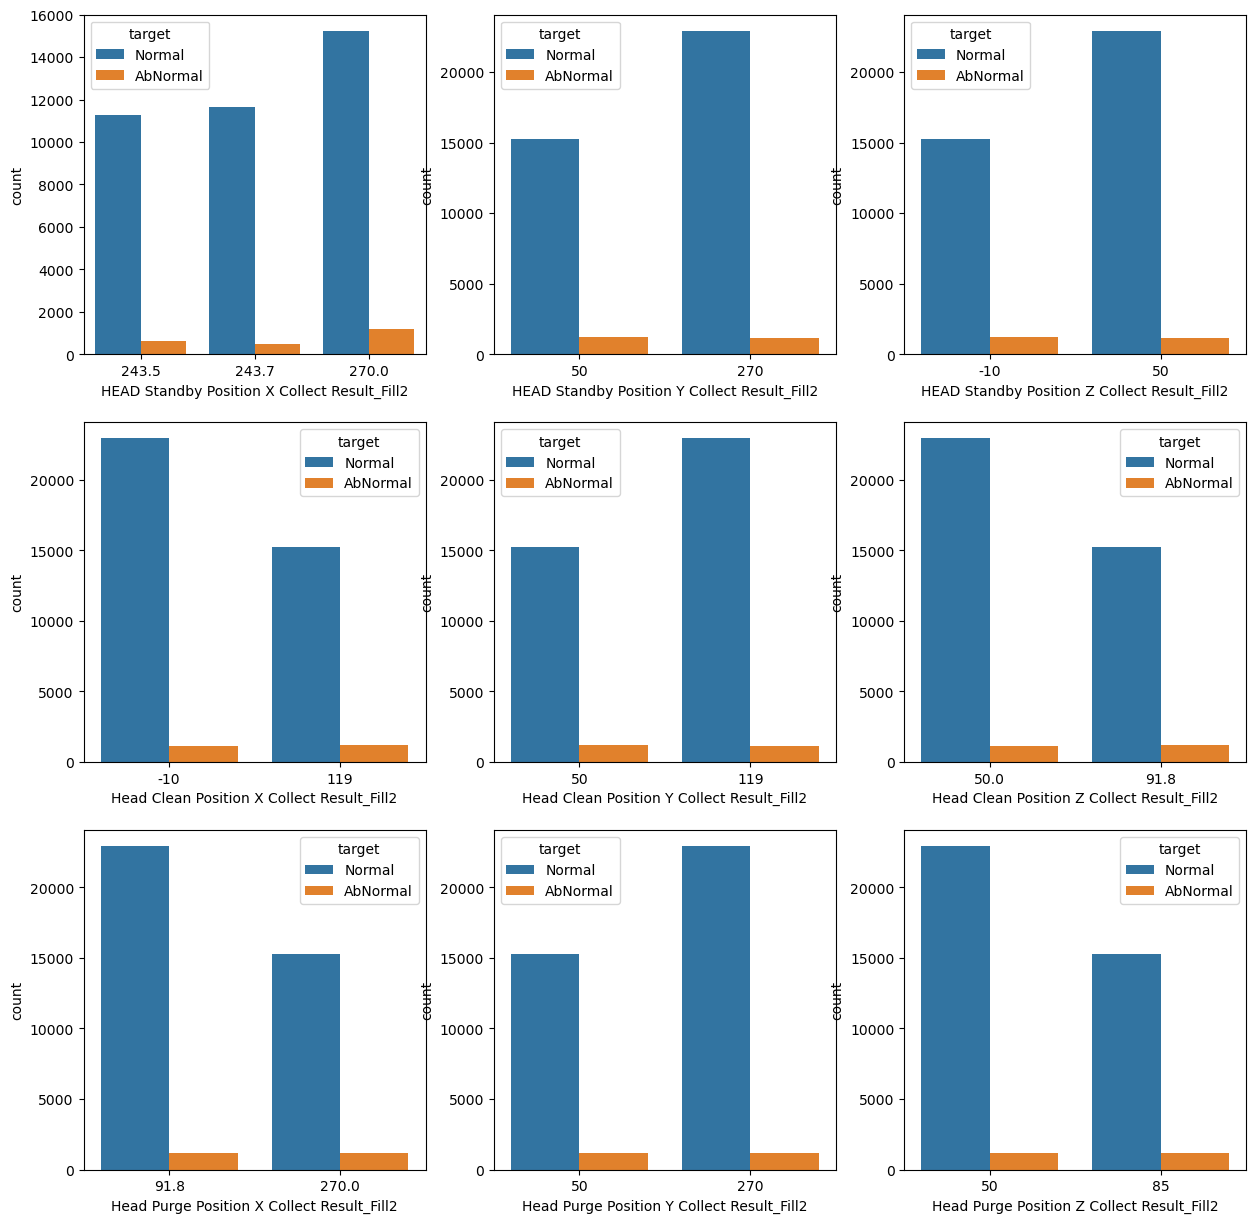

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

sns.countplot(x='HEAD Standby Position X Collect Result_Fill2', hue="target", data=df, ax=axes[0, 0]);
sns.countplot(x='HEAD Standby Position Y Collect Result_Fill2', hue="target", data=df, ax=axes[0, 1]);
sns.countplot(x='HEAD Standby Position Z Collect Result_Fill2', hue="target", data=df, ax=axes[0, 2]);

sns.countplot(x='Head Clean Position X Collect Result_Fill2', hue="target", data=df, ax=axes[1, 0]);
sns.countplot(x='Head Clean Position Y Collect Result_Fill2', hue="target", data=df, ax=axes[1, 1]);
sns.countplot(x='Head Clean Position Z Collect Result_Fill2', hue="target", data=df, ax=axes[1, 2])

sns.countplot(x='Head Purge Position X Collect Result_Fill2', hue="target", data=df, ax=axes[2, 0]);
sns.countplot(x='Head Purge Position Y Collect Result_Fill2', hue="target", data=df, ax=axes[2, 1]);
sns.countplot(x='Head Purge Position Z Collect Result_Fill2', hue="target", data=df, ax=axes[2, 2])

In [62]:
# X만 Standby 분포가 이상해서 확인
# X도 PCA 가능할 듯!

df[["HEAD Standby Position X Collect Result_Fill2", "Head Clean Position X Collect Result_Fill2", "Head Purge Position X Collect Result_Fill2"]].corr()

,HEAD Standby Position X Collect Result_Fill2,Head Clean Position X Collect Result_Fill2,Head Purge Position X Collect Result_Fill2
HEAD Standby Position X Collect Result_Fill2,1.000000,0.999982,0.999982
Head Clean Position X Collect Result_Fill2,0.999982,1.000000,1.000000
Head Purge Position X Collect Result_Fill2,0.999982,1.000000,1.000000


In [63]:
# X standby/clean/purge PCA => 열 생성

x = df[["HEAD Standby Position X Collect Result_Fill2", "Head Clean Position X Collect Result_Fill2", "Head Purge Position X Collect Result_Fill2"]]
x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

from sklearn.decomposition import PCA

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
pca_result = pca.fit_transform(x)

df["X Standby/Clean/Purge PCA_Fill2"] = pca_result

In [64]:
# Y standby/clean/purge PCA => 열 생성

x = df[["HEAD Standby Position Y Collect Result_Fill2", "Head Clean Position Y Collect Result_Fill2", "Head Purge Position Y Collect Result_Fill2"]]
x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

from sklearn.decomposition import PCA

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
pca_result = pca.fit_transform(x)

df["Y Standby/Clean/Purge PCA_Fill2"] = pca_result

In [65]:
# Z standby/clean/purge PCA => 열 생성

x = df[["HEAD Standby Position Z Collect Result_Fill2", "Head Clean Position Z Collect Result_Fill2", "Head Purge Position Z Collect Result_Fill2"]]
x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

from sklearn.decomposition import PCA

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
pca_result = pca.fit_transform(x)

df["Z Standby/Clean/Purge PCA_Fill2"] = pca_result

In [66]:
# 9개 전체 PCA => 열 생성

x = SCP_df
x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

from sklearn.decomposition import PCA

pca = PCA(n_components=1) # 주성분을 몇개로 할지 결정
pca_result = pca.fit_transform(x)

df["XYZ Standby/Clean/Purge PCA_Fill2"] = pca_result

In [67]:
list(df.columns)

['Equipment_Dam',
 'CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE SPEED Collect Result_Dam',
 'CURE STANDBY POSITION X Collect Result_Dam',
 'CURE STANDBY POSITION Z Collect Result_Dam',
 'CURE STANDBY POSITION Θ Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Z Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 '